# Business problems:
Cửa hàng X chủ yếu bán các sản phẩm thiết
yếu cho khách hàng như rau, củ, quả, thịt, cá,
trứng, sữa, nước giải khát... Khách hàng của
cửa hàng là khách hàng mua lẻ.

Chủ cửa hàng X mong muốn có thể bán được
nhiều hàng hóa hơn cũng như giới thiệu sản
phẩm đến đúng đối tượng khách hàng, chăm
sóc và làm hài lòng khách hàng.


## Project Description:
Use RFM (Redency (R) - Frequency (F) - Monetary (M)) to do segmentation using the known customer data.
Depends on the segments, marketing and engament campaigns will be built to increase the new sales, customer satisfaction and engagements.

## Understanding the dataset
Products_with_Categories.csv: all product lines with price andc category.
Transactions.csv: transaction data included: Member_number (named customer), Date (date of transaction), productId (ID of item), Items (number of items)

# 2. Data Preparation 

### 2.1 import libs

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime
# Increase the maximum column width to display full text
pd.set_option('display.max_colwidth', None)

### 2.2 Read two files and explore data

In [97]:
trans_df = pd.read_csv('./Transactions.csv')
prod_df = pd.read_csv('./Products_with_Categories.csv')


In [98]:
prod_df.describe()

,productId,price
count,167.00000,167.000000
mean,84.00000,6.040180
std,48.35287,4.949217
min,1.00000,0.300000
25%,42.50000,2.500000
50%,84.00000,4.900000
75%,125.50000,8.500000
max,167.00000,28.500000


In [99]:
prod_df.head()

,productId,productName,price,Category
0,1,tropical fruit,7.8,Fresh Food
1,2,whole milk,1.8,Dairy
2,3,pip fruit,3.0,Fresh Food
3,4,other vegetables,0.8,Fresh Food
4,5,rolls/buns,1.2,Bakery & Sweets


In [100]:
trans_df.describe()

,Member_number,productId,items
count,38765.000000,38765.000000,38765.000000
mean,3003.641868,39.956094,1.996131
std,1153.611031,37.294166,0.817645
min,1000.000000,1.000000,1.000000
25%,2002.000000,9.000000,1.000000
50%,3005.000000,25.000000,2.000000
75%,4007.000000,64.000000,3.000000
max,5000.000000,167.000000,3.000000


In [101]:
trans_df.head()

,Member_number,Date,productId,items
0,1808,21-07-2015,1,3
1,2552,05-01-2015,2,1
2,2300,19-09-2015,3,3
3,1187,12-12-2015,4,3
4,3037,01-02-2015,2,1


### 2.3 some sanity checks before moving forward

In [102]:
prod_df.isnull().sum()

productId      0
productName    0
price          0
Category       0
dtype: int64

In [103]:
trans_df.isnull().sum()

Member_number    0
Date             0
productId        0
items            0
dtype: int64

In [104]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  38765 non-null  int64 
 1   Date           38765 non-null  object
 2   productId      38765 non-null  int64 
 3   items          38765 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB


In [105]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    167 non-null    int64  
 1   productName  167 non-null    object 
 2   price        167 non-null    float64
 3   Category     167 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB


### 2.4 Data Transformation - Conversion

In [106]:
# 1.Convert Date to datetime format early in the analysis
trans_df['Date'] = pd.to_datetime(trans_df['Date'], format='%d-%m-%Y')

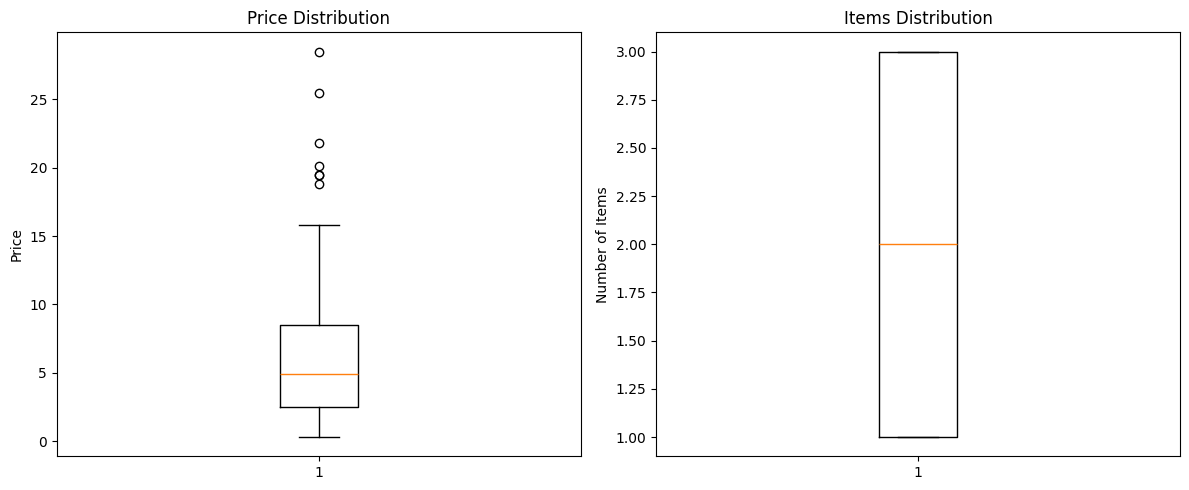

In [107]:
# 2. Check for outliers in price and items
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(prod_df['price'])
plt.title('Price Distribution')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
plt.boxplot(trans_df['items'])
plt.title('Items Distribution')
plt.ylabel('Number of Items')

plt.tight_layout()
plt.show()

#### Comment: Even though there are outliners in the price distribution, but we wouldn't want to remove those as they actually represent the most valuable customers.

In [108]:
# 3. Check data types and convert if necessary
print("Transaction DataFrame Data Types:")
print(trans_df.dtypes)
print("\nProduct DataFrame Data Types:")
print(prod_df.dtypes)

# 4. Check for duplicate transactions
duplicate_trans = trans_df.duplicated(subset=['Member_number', 'Date', 'productId', 'items'])
print(f"\nNumber of duplicate transactions: {duplicate_trans.sum()}")
if duplicate_trans.sum() > 0:
    # Remove duplicates if any exist
    trans_df = trans_df.drop_duplicates(subset=['Member_number', 'Date', 'productId', 'items'])
    print("Duplicates removed.")


Transaction DataFrame Data Types:
Member_number             int64
Date             datetime64[ns]
productId                 int64
items                     int64
dtype: object

Product DataFrame Data Types:
productId        int64
productName     object
price          float64
Category        object
dtype: object

Number of duplicate transactions: 244
Duplicates removed.


#### Comment: Data type is OK, remove some duplicated transaction with same date, same customer, same product and same quantity.
#### NOTE: There is no unique ID of the order (e.g. order_id) to distinguish the orders, there is also the possibility that one customer, by the same thing, same ammount mutliple times in a day. We clean this just because we want assump that those are duplicated.

In [109]:
### 5 merge two df so that trans df get also the other info

In [110]:
detailed_trans_df = pd.merge(trans_df,prod_df,on="productId")

In [111]:
detailed_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38521 entries, 0 to 38520
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Member_number  38521 non-null  int64         
 1   Date           38521 non-null  datetime64[ns]
 2   productId      38521 non-null  int64         
 3   items          38521 non-null  int64         
 4   productName    38521 non-null  object        
 5   price          38521 non-null  float64       
 6   Category       38521 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 2.1+ MB


In [112]:
detailed_trans_df.head()

,Member_number,Date,productId,items,productName,price,Category
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy


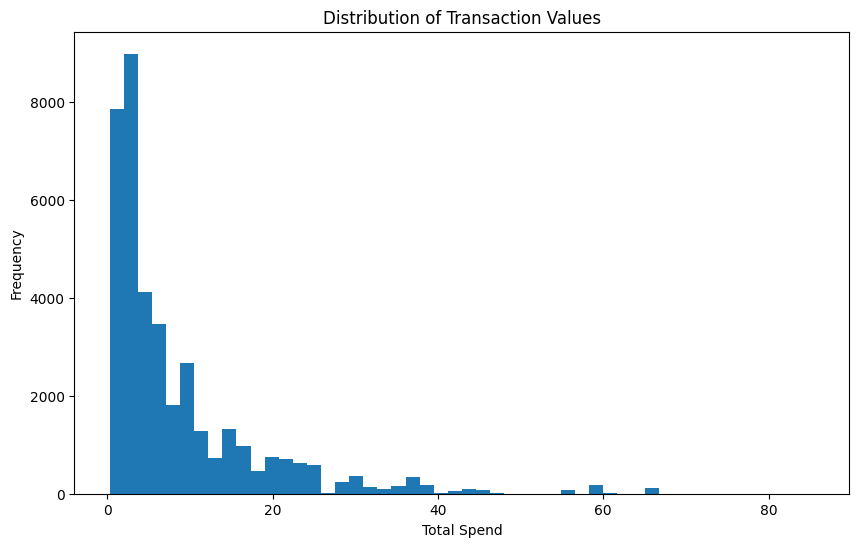


Summary statistics for total spend:
count    38521.000000
mean         8.590893
std          9.952770
min          0.300000
25%          2.400000
50%          5.200000
75%         10.500000
max         85.500000
Name: total_spend, dtype: float64

Number of potential outlier transactions: 3332
Percentage of transactions that are outliers: 8.65%

Top 10 highest transaction values:
       Member_number       Date  productId     productName  items  price  \
3373            1654 2015-03-25        139          whisky      3   28.5   
5069            1090 2015-08-31        139          whisky      3   28.5   
1489            2070 2015-12-19        112  baby cosmetics      3   25.5   
37459           1552 2014-01-09        112  baby cosmetics      3   25.5   
1546            1742 2015-07-05        114         napkins      3   21.8   
1569            2151 2015-09-29        114         napkins      3   21.8   
1638            4519 2015-11-03        114         napkins      3   21.8   
3618     

In [113]:
# 6. Check for unusual values in monetary calculations
detailed_trans_df['total_spend'] = detailed_trans_df["items"] * detailed_trans_df["price"]
plt.figure(figsize=(10, 6))
plt.hist(detailed_trans_df['total_spend'], bins=50)
plt.title('Distribution of Transaction Values')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
print("\nSummary statistics for total spend:")
print(detailed_trans_df['total_spend'].describe())

# Identify potential outliers using IQR method
Q1 = detailed_trans_df['total_spend'].quantile(0.25)
Q3 = detailed_trans_df['total_spend'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Count and display outliers
outliers = detailed_trans_df[detailed_trans_df['total_spend'] > outlier_threshold]
print(f"\nNumber of potential outlier transactions: {len(outliers)}")
print(f"Percentage of transactions that are outliers: {(len(outliers)/len(detailed_trans_df))*100:.2f}%")

# Look at the top outliers
print("\nTop 10 highest transaction values:")
print(detailed_trans_df.nlargest(10, 'total_spend')[['Member_number', 'Date', 'productId', 'productName', 'items', 'price', 'total_spend']])

# Note: For RFM analysis, we typically don't remove these outliers as they represent valuable customers
# Instead, we should be aware of them when interpreting results

#### comment: same as above, we don't see high values as outliner as those represent high value customers.

### 2.5 grouping data so that if a customer has multiple transactions a day, sum those into one.

In [114]:
# check if any user has more than one transaction a day
# Group by Member_number and Date, count transactions, and filter where count > 1
multiple_trans_per_day = detailed_trans_df.groupby(['Member_number', 'Date']).size().reset_index(name='transaction_count')
multiple_trans_per_day = multiple_trans_per_day[multiple_trans_per_day['transaction_count'] > 1]

print("Members with multiple transactions in a day:")
print(multiple_trans_per_day)


Members with multiple transactions in a day:
       Member_number       Date  transaction_count
0               1000 2014-06-24                  3
1               1000 2015-03-15                  4
2               1000 2015-05-27                  2
3               1000 2015-07-24                  2
4               1000 2015-11-25                  2
...              ...        ...                ...
14958           4999 2015-05-16                  2
14959           4999 2015-12-26                  2
14960           5000 2014-03-09                  2
14961           5000 2014-11-16                  2
14962           5000 2015-02-10                  3

[14901 rows x 3 columns]


In [115]:
# calculate the total_spend per transaction by items*price
# detailed_trans_df['total_spend'] = detailed_trans_df["items"] * detailed_trans_df["price"]

In [116]:
detailed_trans_df.head()

,Member_number,Date,productId,items,productName,price,Category,total_spend
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food,23.4
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy,1.8
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food,9.0
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food,2.4
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy,1.8


In [117]:
# as we use date as the resultion for Redency, group transaction by date
# and calculate sum per day.
daily_trans_df = detailed_trans_df[['Member_number','Date','total_spend']]
daily_trans_df = daily_trans_df.groupby(['Member_number', 'Date']).sum(['total_spend']).reset_index()
daily_trans_df.sort_values(by=['Date'],ascending=False,inplace=True)

In [118]:
# check if any user has more than one transaction a day -> should be no duplications now.
multiple_trans_per_day = daily_trans_df.groupby(['Member_number', 'Date']).size().reset_index(name='transaction_count')
multiple_trans_per_day = multiple_trans_per_day[multiple_trans_per_day['transaction_count'] > 1]

print("Members with multiple transactions in a day:")
print(multiple_trans_per_day)

Members with multiple transactions in a day:
Empty DataFrame
Columns: [Member_number, Date, transaction_count]
Index: []


In [119]:
daily_trans_df.head()

,Member_number,Date,total_spend
5595,2507,2015-12-30,37.1
6769,2810,2015-12-30,14.0
13329,4565,2015-12-30,1.1
7342,2970,2015-12-30,23.4
4249,2140,2015-12-30,7.0


# 3 Modeling and Eveluation

### 3.1 Redency, Frequency, Monetary calculations

In [120]:
# Calculate Redency (R) - Frequency (F) and Monetary (M) (model RFM)
# create new data frame where 1 row is a user, with 3 other columns: R, F and M
# R = today - maximum date in the dataset
# F = count how many rows per user
# M = sum of total_spend per user


# Convert Date to datetime format first
daily_trans_df['Date'] = pd.to_datetime(daily_trans_df['Date'], format='%d-%m-%Y')

# Set the reference date as the maximum date in the dataset
max_date = daily_trans_df['Date'].max().date()

# Create RFM dataframe
rfm_df = daily_trans_df.groupby('Member_number').agg(
    Recency=('Date', lambda x: (max_date - x.max().date()).days),
    Frequency=('Date', 'count'),
    Monetary=('total_spend', 'sum')
).reset_index()

rfm_df.head()

,Member_number,Recency,Frequency,Monetary
0,1000,35,5,53.80
1,1001,242,5,100.00
2,1002,122,4,70.30
3,1003,323,4,60.65
4,1004,28,8,204.96


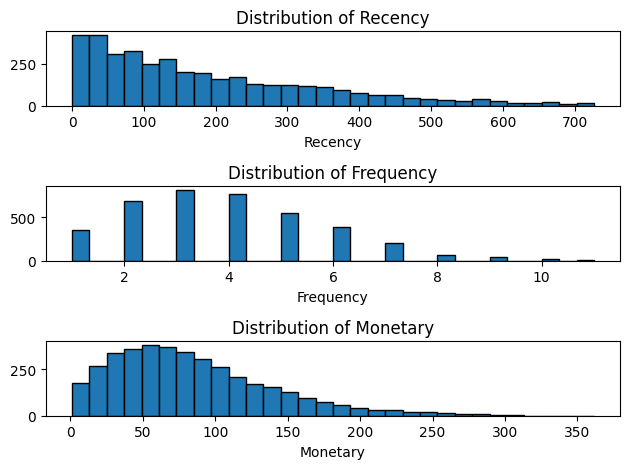

In [121]:
# distribution
# 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(rfm_df['Recency'], bins=30, edgecolor='black')
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(rfm_df['Frequency'], bins=30, edgecolor='black')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(rfm_df['Monetary'], bins=30, edgecolor='black') 
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

### Comment: Distribution Analysis

#### Recency Distribution
The histogram shows that most customers have relatively low recency values, typically between 0-100 days, indicating that many customers have made purchases fairly recently. The distribution is right-skewed with a long tail, suggesting that while most customers are active, there's a segment that hasn't purchased in a longer time. 

#### Frequency Distribution
The frequency histogram reveals that the majority of customers have made very few purchases (1-5 transactions). The distribution is heavily right-skewed with a long tail, demonstrating that only a small number of customers make frequent purchases. 

#### Monetary Distribution
Similar to frequency, the monetary distribution is heavily right-skewed. Most customers have spent relatively small amounts, while a few customers have spent significantly more.
 
#### Overall RFM Insights
The distributions confirm typical retail customer behavior patterns where:
1. A core group of recent, frequent, and high-spending customers drive significant business value
2. A large segment of customers shop occasionally with moderate spending
3. There's opportunity to re-engage customers with higher recency values
4. The high-value customers (high frequency and monetary) represent prime targets for retention strategies


### 3.2 Calculate RFM quartile

In [122]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(4, 0, -1) # higer days -> lower rank
f_labels = range(1, 5)
m_labels = range(1, 5)

In [123]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(rfm_df['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(rfm_df['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [124]:
# Create new columns R, F, M
rfm_df = rfm_df.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M
0,1000,35,5,53.80,4,3,2
1,1001,242,5,100.00,2,3,3
2,1002,122,4,70.30,3,2,2
3,1003,323,4,60.65,1,2,2
4,1004,28,8,204.96,4,4,4


In [125]:
#calculate RFM score
rfm_df['RFM_Score'] = rfm_df['R'].astype(int) + rfm_df['F'].astype(int) + rfm_df['M'].astype(int)
rfm_df.head()


,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,1000,35,5,53.80,4,3,2,9
1,1001,242,5,100.00,2,3,3,8
2,1002,122,4,70.30,3,2,2,7
3,1003,323,4,60.65,1,2,2,5
4,1004,28,8,204.96,4,4,4,12


In [126]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Member_number  3898 non-null   int64   
 1   Recency        3898 non-null   int64   
 2   Frequency      3898 non-null   int64   
 3   Monetary       3898 non-null   float64 
 4   R              3898 non-null   category
 5   F              3898 non-null   category
 6   M              3898 non-null   category
 7   RFM_Score      3898 non-null   int32   
dtypes: category(3), float64(1), int32(1), int64(3)
memory usage: 149.0 KB


In [127]:
# convert R F and M to int
rfm_df['R'] = rfm_df['R'].astype(int)
rfm_df['F'] = rfm_df['F'].astype(int)
rfm_df['M'] = rfm_df['M'].astype(int)
rfm_df.info()
rfm_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Member_number  3898 non-null   int64  
 1   Recency        3898 non-null   int64  
 2   Frequency      3898 non-null   int64  
 3   Monetary       3898 non-null   float64
 4   R              3898 non-null   int32  
 5   F              3898 non-null   int32  
 6   M              3898 non-null   int32  
 7   RFM_Score      3898 non-null   int32  
dtypes: float64(1), int32(4), int64(3)
memory usage: 182.8 KB


,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,1000,35,5,53.80,4,3,2,9
1,1001,242,5,100.00,2,3,3,8
2,1002,122,4,70.30,3,2,2,7
3,1003,323,4,60.65,1,2,2,5
4,1004,28,8,204.96,4,4,4,12


In [128]:
rfm_df.tail()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score
3893,4996,36,3,28.50,4,2,1,7
3894,4997,3,2,93.00,4,2,3,9
3895,4998,77,1,33.00,3,1,1,5
3896,4999,4,6,164.86,4,4,4,12
3897,5000,323,3,21.80,1,2,1,4


In [129]:
import pickle

In [130]:
# dump this to pkl file
# Add the dump here:
rfm_results = {
    'rfm_df': rfm_df,
    'r_labels': r_labels,
    'f_labels': f_labels,
    'm_labels': m_labels,
    'RFM_Score': rfm_df['RFM_Score']
}

with open('data/rfm_segments.pkl', 'wb') as f:
    pickle.dump(rfm_results, f)

### 3.3 Manual segmentation


In [131]:
# Define a segmentation approach focused on spend and frequency, with an inactive group
def get_Customer_Segment_manual(row):
    # Inactive Customers: Haven't purchased in a long time (low recency score)
    if (row['R'] == 1):
        return 'Inactive Customers'
    
    # VIP Customers: High frequency and high monetary value
    elif (row['F'] >= 4) and (row['M'] >= 4):
        return 'VIP Customers'
    
    # Big Spenders: Moderate frequency but high monetary value
    elif (row['F'] >= 2) and (row['M'] >= 4):
        return 'Big Spenders'
    
    # Regular Customers: average frequency but moderate spending
    elif (row['F'] >= 2) and (row['M'] >= 2):
        return 'Regular Customers'
    
    # Occasional Customers: Everyone else who is still active
    else:
        return 'Occasional Customers'

# Apply the segmentation function
rfm_df['Customer_Segment_manual'] = rfm_df.apply(get_Customer_Segment_manual, axis=1)


# Calculate segment statistics
segment_stats = rfm_df.groupby('Customer_Segment_manual').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'sum'],
    'Member_number': 'count'
})

# Calculate percentage of total monetary value
segment_stats[('Monetary', 'pct_total')] = segment_stats[('Monetary', 'sum')] / rfm_df['Monetary'].sum() * 100

# Calculate percentage of customers
segment_stats[('Member_number', 'pct_total')] = segment_stats[('Member_number', 'count')] / len(rfm_df) * 100

print("Customer Segment manual Statistics:")
segment_stats.round(2)

Customer Segment manual Statistics:


Recency        Frequency        Monetary          \
                           mean median      mean median     mean  median   
Customer_Segment_manual                                                    
Big Spenders             109.26   91.0      4.16    4.0   147.33  139.40   
Inactive Customers       419.81  390.0      2.65    2.0    54.74   45.80   
Occasional Customers     132.37  134.0      2.18    2.0    38.20   34.60   
Regular Customers        109.38   95.5      4.22    4.0    79.38   79.55   
VIP Customers             87.14   65.0      6.68    6.0   170.60  159.51   

                                   Member_number  Monetary Member_number  
                               sum         count pct_total     pct_total  
Customer_Segment_manual                                                   
Big Spenders              41104.26           279     12.42          7.16  
Inactive Customers        53370.89           975     16.13         25.01  
Occasional Customers      26971.59           706      8.15         18.11  
Regular Customers        105417.07          1328     31.85         34.07  
VIP Customers            104065.99           610     31.45         15.65

In [132]:
# Visualize the clusters in 3D - interactively
from visualization_utils import plot_3d_segments


# Visualize the distribution of manual segments
manual_counts = rfm_df['Customer_Segment_manual'].value_counts().reset_index()
manual_counts.columns = ['Segment', 'Count']
manual_counts['Percentage'] = manual_counts['Count'] / manual_counts['Count'].sum() * 100

fig_Manual = plot_3d_segments(rfm_df,color_column='Customer_Segment_manual', color_discrete_sequence=px.colors.qualitative.Vivid,title='Manual Customer Segments 3D plot')
fig_Manual.show()

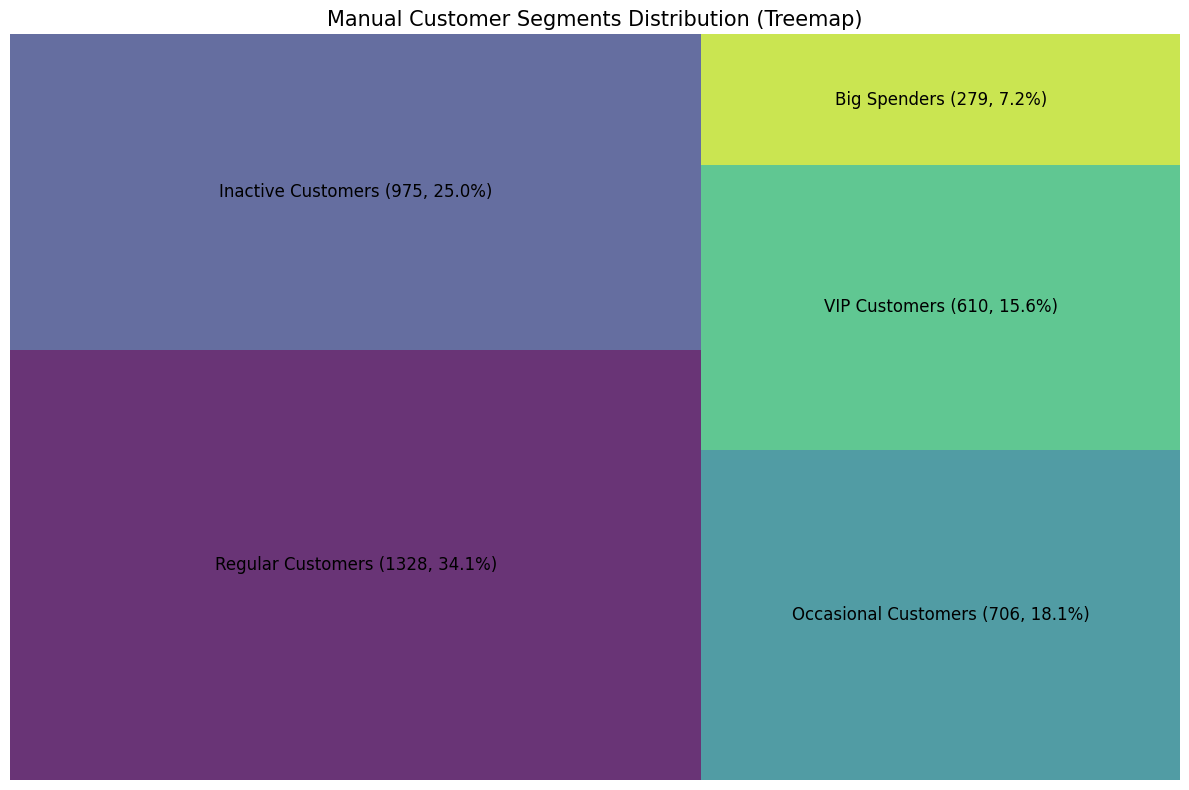

In [133]:
# Create a treemap visualization of customer segments using squarify
# For manual segmentation
from visualization_utils import plot_segment_treemap

fig_manual = plot_segment_treemap(
    rfm_df, 
    segment_column='Customer_Segment_manual',
    title='Manual Customer Segments Distribution (Treemap)'
)
plt.show()



### 3.3 Segmentation using KMeans


In [134]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [135]:

# Select the RFM features for clustering
features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Standardize the data (important for K-means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Find the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(features_scaled, labels))



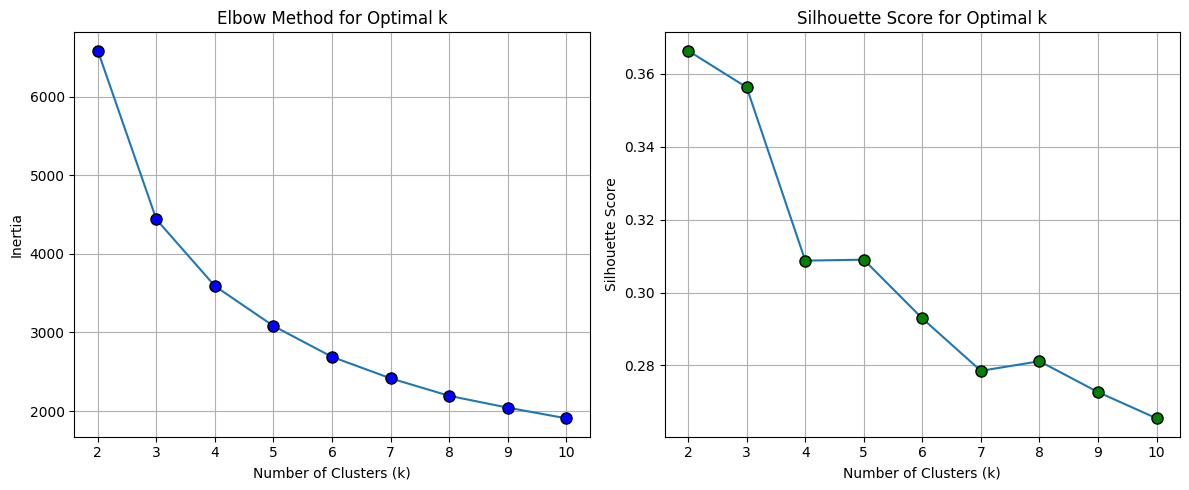

In [136]:
# Plot the Elbow Method results
plt.figure(figsize=(12, 5))

# Plot 1: Inertia (Elbow Method)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-', markersize=8, markerfacecolor='blue', markeredgecolor='black')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Plot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', markersize=8, markerfacecolor='green', markeredgecolor='black')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()




In [137]:
# Based on the elbow method and silhouette score, choose the optimal k
optimal_k = 5 

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(features_scaled)

# Analyze the clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=['Recency', 'Frequency', 'Monetary'])
cluster_summary['Count'] = rfm_df['Cluster'].value_counts().sort_index().values
cluster_summary['Percentage'] = cluster_summary['Count'] / cluster_summary['Count'].sum() * 100

# Sort clusters by their characteristics to identify their roles
recency_rank = cluster_summary['Recency'].rank()  # Lower is better (more recent)
frequency_rank = cluster_summary['Frequency'].rank(ascending=False)  # Higher is better
monetary_rank = cluster_summary['Monetary'].rank(ascending=False)  # Higher is better

# Calculate a combined score (lower recency, higher F and M is better)
cluster_summary['combined_score'] = frequency_rank + monetary_rank - recency_rank

# Sort by the combined score to identify the best and worst clusters
cluster_summary = cluster_summary.sort_values('combined_score', ascending=False)
# Add descriptions based on the actual cluster centers
segment_descriptions = []
for i, row in cluster_summary.iterrows():
    desc = f"Recency: {row['Recency']:.1f} days, " + \
           f"Frequency: {row['Frequency']:.1f} purchases, " + \
           f"Monetary: ${row['Monetary']:.2f}"
    segment_descriptions.append(desc)

cluster_summary['Description'] = segment_descriptions

In [138]:
cluster_summary

,Recency,Frequency,Monetary,Count,Percentage,combined_score,Description
0,115.400756,2.552930,47.159178,1060,27.193433,5.0,"Recency: 115.4 days, Frequency: 2.6 purchases, Monetary: $47.16"
1,457.798374,1.814634,32.852927,616,15.802976,5.0,"Recency: 457.8 days, Frequency: 1.8 purchases, Monetary: $32.85"
4,84.180712,4.792135,103.261142,1066,27.347358,3.0,"Recency: 84.2 days, Frequency: 4.8 purchases, Monetary: $103.26"
3,302.935897,3.833333,84.073878,622,15.956901,2.0,"Recency: 302.9 days, Frequency: 3.8 purchases, Monetary: $84.07"
2,92.088180,6.821764,184.025966,534,13.699333,0.0,"Recency: 92.1 days, Frequency: 6.8 purchases, Monetary: $184.03"


In [139]:
# Assign segment names based on cluster characteristics

# Sort by the combined score to identify the best and worst clusters
h_cluster_summary = cluster_summary.sort_values('combined_score', ascending=False)

segment_names = []

for i, row in cluster_summary.iterrows():
    # High value customers - high frequency and monetary
    if row['Monetary'] > 150:
        segment_names.append("High Spenders")
    # Recent customers with good frequency
    elif row['Recency'] < 100 and row['Frequency'] > 3:
        segment_names.append("Loyal Customers")
    # Customers who haven't purchased in a long time
    elif row['Recency'] > 450:
        segment_names.append("Hibernating")
    # Customers with moderate recency and frequency
    elif row['Recency'] < 250 and row['Frequency'] > 2:
        segment_names.append("Regular Customers")
    # Everyone else
    else:
        segment_names.append("At-Risk Customers")

# Assign the names to the DataFrame
cluster_summary['segment_names'] = segment_names

In [140]:
# double check if characteristic and names are alligned
cluster_summary

,Recency,Frequency,Monetary,Count,Percentage,combined_score,Description,segment_names
0,115.400756,2.552930,47.159178,1060,27.193433,5.0,"Recency: 115.4 days, Frequency: 2.6 purchases, Monetary: $47.16",Regular Customers
1,457.798374,1.814634,32.852927,616,15.802976,5.0,"Recency: 457.8 days, Frequency: 1.8 purchases, Monetary: $32.85",Hibernating
4,84.180712,4.792135,103.261142,1066,27.347358,3.0,"Recency: 84.2 days, Frequency: 4.8 purchases, Monetary: $103.26",Loyal Customers
3,302.935897,3.833333,84.073878,622,15.956901,2.0,"Recency: 302.9 days, Frequency: 3.8 purchases, Monetary: $84.07",At-Risk Customers
2,92.088180,6.821764,184.025966,534,13.699333,0.0,"Recency: 92.1 days, Frequency: 6.8 purchases, Monetary: $184.03",High Spenders


In [141]:
# Map cluster labels back to the original dataframe
# Create a mapping from original cluster numbers to segment names
original_indices = cluster_summary.index.tolist()
cluster_mapping = dict(zip(original_indices, cluster_summary['segment_names']))
rfm_df['KMeans_Segment'] = rfm_df['Cluster'].map(cluster_mapping)

In [142]:
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score,Customer_Segment_manual,Cluster,KMeans_Segment
0,1000,35,5,53.80,4,3,2,9,Regular Customers,4,Loyal Customers
1,1001,242,5,100.00,2,3,3,8,Regular Customers,3,At-Risk Customers
2,1002,122,4,70.30,3,2,2,7,Regular Customers,4,Loyal Customers
3,1003,323,4,60.65,1,2,2,5,Inactive Customers,3,At-Risk Customers
4,1004,28,8,204.96,4,4,4,12,VIP Customers,2,High Spenders


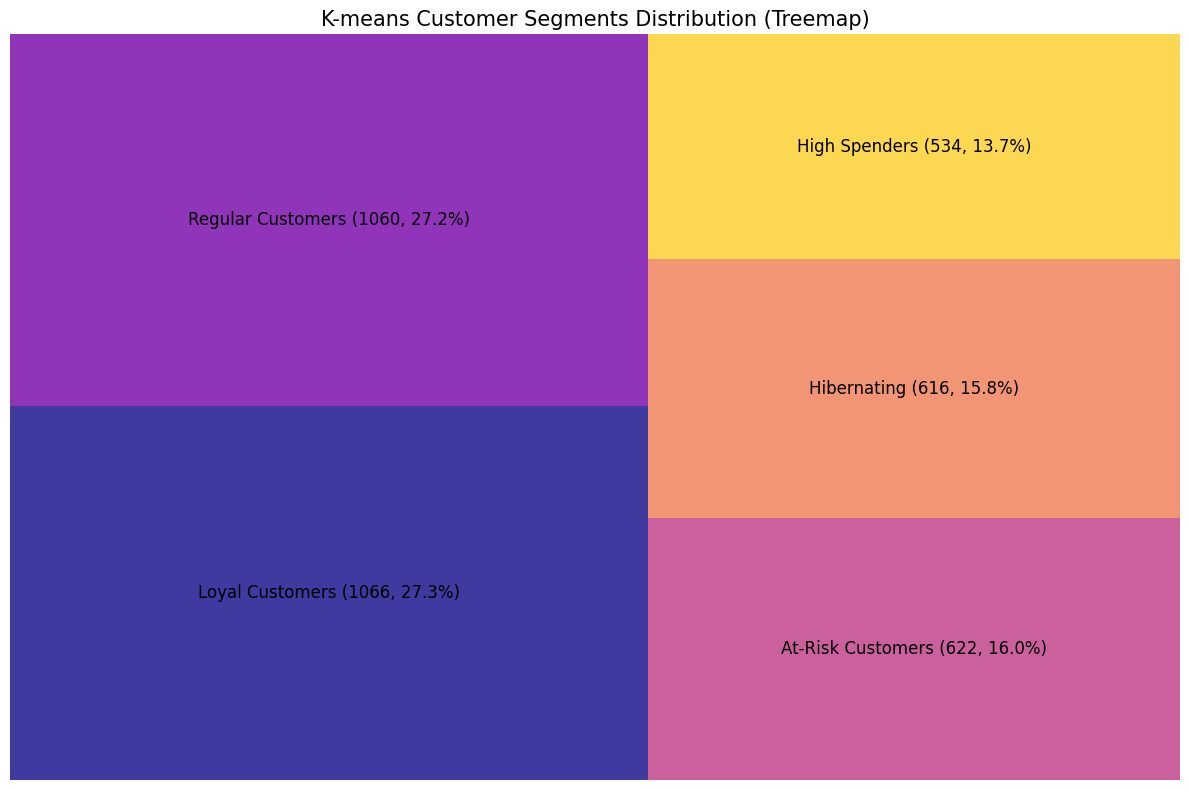

In [143]:
# visualization in tree map
# For K-means segmentation
fig_kmeans = plot_segment_treemap(
    rfm_df, 
    segment_column='KMeans_Segment',
    title='K-means Customer Segments Distribution (Treemap)',
    colormap='plasma'
)

In [144]:
# Visualize the clusters in 3D - interactively
from visualization_utils import plot_3d_segments
fig_Kmeans = plot_3d_segments(rfm_df,color_column='KMeans_Segment',color_discrete_sequence=px.colors.qualitative.Vivid,title='K-means Customer Segments 3D plot')
fig_Kmeans.show()

In [145]:
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score,Customer_Segment_manual,Cluster,KMeans_Segment
0,1000,35,5,53.80,4,3,2,9,Regular Customers,4,Loyal Customers
1,1001,242,5,100.00,2,3,3,8,Regular Customers,3,At-Risk Customers
2,1002,122,4,70.30,3,2,2,7,Regular Customers,4,Loyal Customers
3,1003,323,4,60.65,1,2,2,5,Inactive Customers,3,At-Risk Customers
4,1004,28,8,204.96,4,4,4,12,VIP Customers,2,High Spenders


In [146]:
# dump Kmeans result

In [147]:
kmeans_results = {
    'model': kmeans,
    'cluster_centers': cluster_centers,
    'cluster_summary': cluster_summary,
    'scaler':scaler,
    'mapping':cluster_mapping,
    'segmented_df': rfm_df[['Member_number', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'KMeans_Segment']]
}

with open('data/kmeans_segments.pkl', 'wb') as f:
    pickle.dump(kmeans_results, f)

In [148]:
# Compare with previous segmentation using crosstab
comparison_df = pd.crosstab(rfm_df['Customer_Segment_manual'], rfm_df['KMeans_Segment'])
print("Comparison between manual segmentation and K-means clustering:")
comparison_df


Comparison between manual segmentation and K-means clustering:


KMeans_Segment,At-Risk Customers,Hibernating,High Spenders,Loyal Customers,Regular Customers
Customer_Segment_manual,,,,,
Big Spenders,25,0,48,205,1
Inactive Customers,360,600,14,0,1
Occasional Customers,16,16,0,10,664
Regular Customers,217,0,8,709,394
VIP Customers,4,0,464,142,0


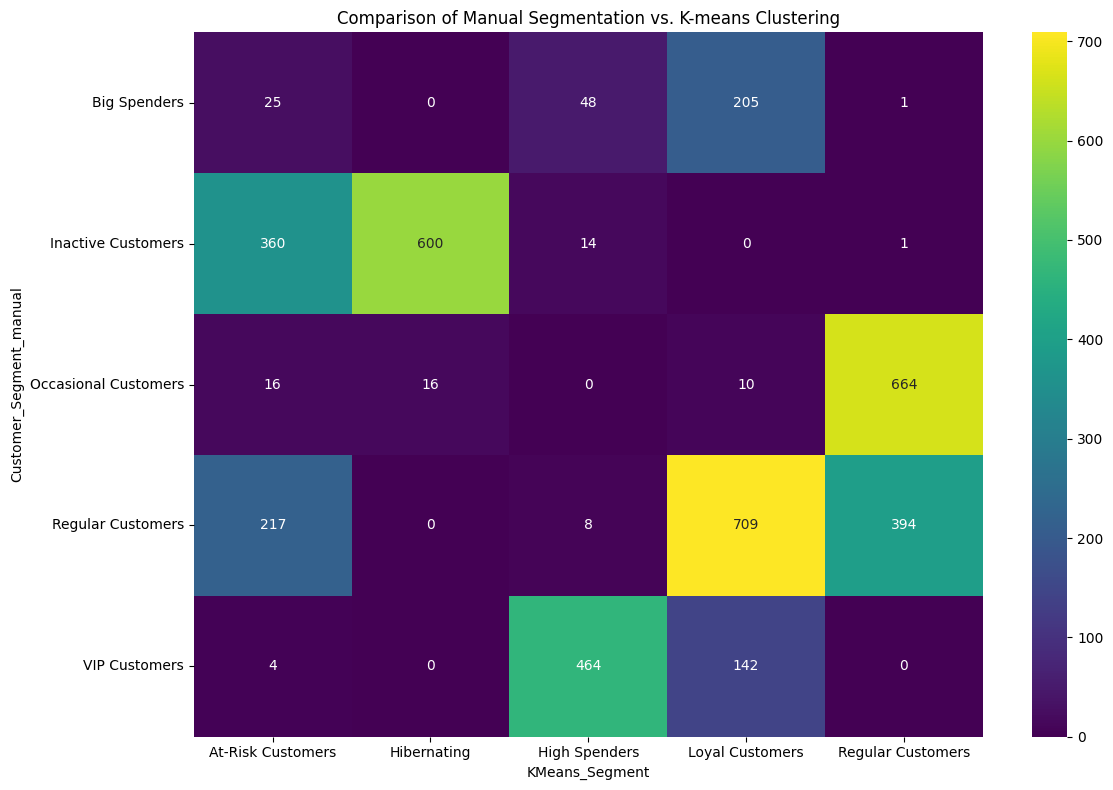

In [149]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(comparison_df, annot=True, cmap='viridis', fmt='d')
plt.title('Comparison of Manual Segmentation vs. K-means Clustering')
plt.tight_layout()
plt.show()

#### Comment: Analysis of Manual Segmentation vs. K-means Clustering Comparison
Looking at the comparison between manual segmentation and K-means clustering in the heatmap, I can provide the following analysis:

The heatmap reveals several interesting patterns in how these two segmentation approaches classify customers:

## Key Observations

1. **Inactive Customers**: There's strong alignment between methods for inactive customers.    
- The crosstab shows that of the manually labeled "Inactive Customers", 616 were classified as "Hibernating" by K-means
- The remaining were distributed across other K-means segments, primarily "At-Risk Customers"

2. **VIP Customers**: 
- The distribution shows 464 manually labeled "VIP Customers" were classified as "High Spenders" by K-means
- 142 were classified as "Loyal Customers"
- This indicates stronger alignment for high-value customers than I previously noted

3. **Occasional Customers**: 
- The distribution across K-means segments shows significant fragmentation, good alignment with Reglular Customers from Kmeans.

4. **Big Spenders**: 
- Align with "High Spender" and "Loyal Customers" from Kmeans. However, 25 were classified as At-Risk. This suggests K-means is considering recency more heavily in its classification.

5. **Regular Customers**:
- Similar to "Big Spender", manual "Regular Customers" appear to be distributed across "Loyal Customers" and "Regular". 217 were classified as "At-Risk", indicating the algorithmic approach is identifying more complex patterns in their purchasing behavior. 

## Business Implications

- The K-means approach provides more granular segmentation that might better capture nuances in customer behavior, particularly in distinguishing between truly high-value customers and those who might be at risk despite good historical metrics.

- The algorithmic approach may be better at identifying customers showing early warning signs of disengagement that the manual rules-based approach might miss.

- The differences highlight the value of combining business intuition (manual segmentation) with data-driven insights (K-means clustering) for more comprehensive customer understanding.

- Marketing strategies should consider these differences, perhaps focusing on areas of agreement for confident targeting while investigating discrepancies to refine the segmentation approach.



### 3.4 Segmentation using Hierachical Clustering

In [150]:
### Using Hierachical Clustering
# Import necessary libraries for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [151]:
# Select the RFM features for clustering (same as before)
features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Standardize the data (important for hierarchical clustering)
hierachical_scaler = StandardScaler()
features_scaled = hierachical_scaler.fit_transform(features)

# Perform hierarchical clustering using Ward's method
Z = linkage(features_scaled, method='ward')



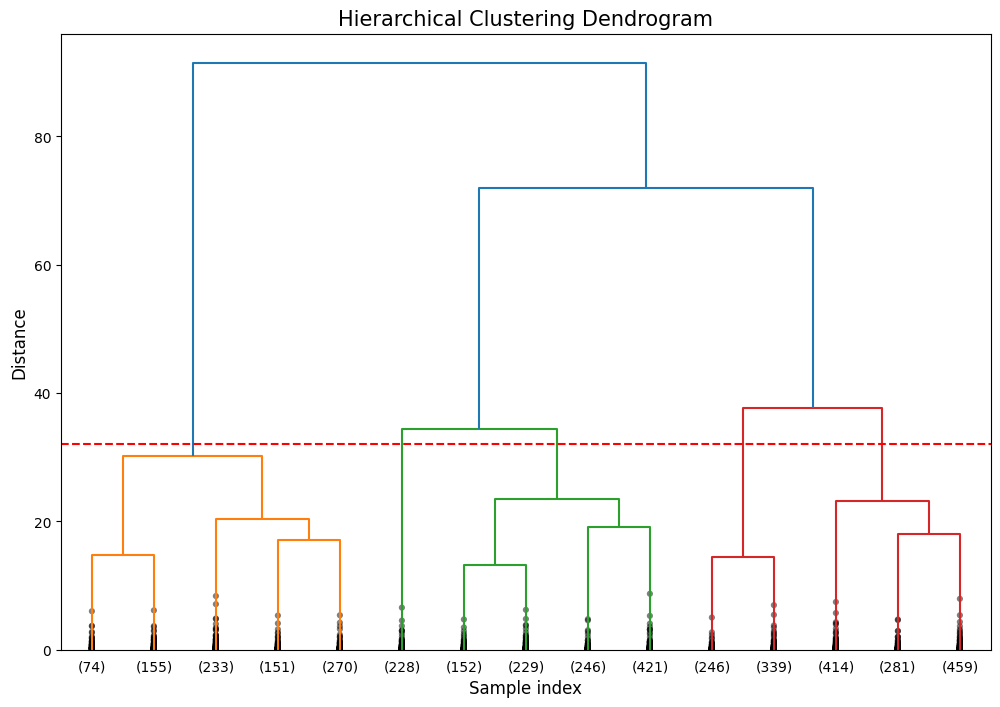

In [152]:
# Plot the dendrogram to visualize the hierarchical structure
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel('Sample index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
dendrogram(Z, truncate_mode='lastp', p=15, leaf_font_size=10, show_contracted=True)
plt.axhline(y=32, color='r', linestyle='--')  # Draw a horizontal line to suggest a cut
plt.show()



In [153]:
# Based on the dendrogram, choose the optimal number of clusters
# Let's use 5 clusters
optimal_h = 5

# Form flat clusters from the hierarchical clustering
rfm_df['Hierarchical_Cluster'] = fcluster(Z, optimal_h, criterion='maxclust')

# Analyze the clusters
hierarchical_centers = []
for i in range(1, optimal_h + 1):  # Hierarchical cluster labels start from 1
    cluster_data = features_scaled[rfm_df['Hierarchical_Cluster'] == i]
    hierarchical_centers.append(np.mean(cluster_data, axis=0))

hierarchical_centers = scaler.inverse_transform(hierarchical_centers)
h_cluster_summary = pd.DataFrame(hierarchical_centers, columns=['Recency', 'Frequency', 'Monetary'])
h_cluster_summary['Count'] = rfm_df['Hierarchical_Cluster'].value_counts().sort_index().values
h_cluster_summary['Percentage'] = h_cluster_summary['Count'] / h_cluster_summary['Count'].sum() * 100

# Print the cluster centers to understand their characteristics
print("Cluster centers before naming:")
print(h_cluster_summary[['Recency', 'Frequency', 'Monetary']])

# Rank clusters by their characteristics
recency_rank = h_cluster_summary['Recency'].rank()  # Lower is better (more recent)
frequency_rank = h_cluster_summary['Frequency'].rank(ascending=False)  # Higher is better
monetary_rank = h_cluster_summary['Monetary'].rank(ascending=False)  # Higher is better

# Calculate a combined score (lower recency, higher F and M is better)
h_cluster_summary['combined_score'] = frequency_rank + monetary_rank - recency_rank

# Sort by the combined score to identify the best and worst clusters
h_cluster_summary = h_cluster_summary.sort_values('combined_score', ascending=False)


# Add descriptions based on the actual cluster centers
segment_descriptions = []
for i, row in h_cluster_summary.iterrows():
    desc = f"Recency: {row['Recency']:.1f} days, " + \
           f"Frequency: {row['Frequency']:.1f} purchases, " + \
           f"Monetary: ${row['Monetary']:.2f}"
    segment_descriptions.append(desc)

h_cluster_summary['Description'] = segment_descriptions





Cluster centers before naming:
      Recency  Frequency    Monetary
0  116.602492   6.075878  164.202367
1  580.570175   1.631579   29.096974
2  322.117366   2.687977   55.364847
3   91.174359   2.362393   38.752000
4   91.346620   4.356153   85.452964


In [154]:

h_cluster_summary

,Recency,Frequency,Monetary,Count,Percentage,combined_score,Description
3,91.174359,2.362393,38.752000,585,15.007696,7.0,"Recency: 91.2 days, Frequency: 2.4 purchases, Monetary: $38.75"
1,580.570175,1.631579,29.096974,228,5.849153,5.0,"Recency: 580.6 days, Frequency: 1.6 purchases, Monetary: $29.10"
2,322.117366,2.687977,55.364847,1048,26.885582,2.0,"Recency: 322.1 days, Frequency: 2.7 purchases, Monetary: $55.36"
4,91.346620,4.356153,85.452964,1154,29.604926,2.0,"Recency: 91.3 days, Frequency: 4.4 purchases, Monetary: $85.45"
0,116.602492,6.075878,164.202367,883,22.652642,-1.0,"Recency: 116.6 days, Frequency: 6.1 purchases, Monetary: $164.20"


In [155]:
# Now assign some meaningful names to segments based on the mean value in each Recency, Frequency, Monetory

# Sort by the combined score to identify the best and worst clusters
h_cluster_summary = h_cluster_summary.sort_values('combined_score', ascending=False)

# Print the characteristics to help with naming
print("Cluster characteristics for naming:")
for i, row in h_cluster_summary.iterrows():
    print(f"Cluster {i+1}: Recency={row['Recency']:.1f}, Frequency={row['Frequency']:.1f}, Monetary=${row['Monetary']:.2f}")

# Now assign segment names based on the specific characteristics of each cluster
segment_names = []

# Assign segment names based on cluster characteristics
for i, row in h_cluster_summary.iterrows():
    # High value customers - high frequency and monetary
    if row['Monetary'] > 150:
        segment_names.append("High Spenders")
    # Recent customers with good frequency
    elif row['Recency'] < 100 and row['Frequency'] > 3:
        segment_names.append("Loyal Customers")
    # Customers who haven't purchased in a long time
    elif row['Recency'] > 450:
        segment_names.append("Hibernating")
    # Customers with moderate recency and frequency
    elif row['Recency'] < 250 and row['Frequency'] > 2:
        segment_names.append("Regular Customers")
    # Everyone else
    else:
        segment_names.append("At-Risk Customers")

# Assign the names to the DataFrame
h_cluster_summary['segment_names'] = segment_names

# Map cluster labels back to the original dataframe
# Create a mapping from original cluster numbers to segment names
original_indices = h_cluster_summary.index.tolist()
h_cluster_mapping = dict(zip([i+1 for i in original_indices], h_cluster_summary['segment_names']))
rfm_df['Hierarchical_Segment'] = rfm_df['Hierarchical_Cluster'].map(h_cluster_mapping)

# Verify we have exactly 6 segments
print(f"\nNumber of unique hierarchical segments: {rfm_df['Hierarchical_Segment'].nunique()}")
print(f"Segment counts:\n{rfm_df['Hierarchical_Segment'].value_counts()}")

Cluster characteristics for naming:
Cluster 4: Recency=91.2, Frequency=2.4, Monetary=$38.75
Cluster 2: Recency=580.6, Frequency=1.6, Monetary=$29.10
Cluster 3: Recency=322.1, Frequency=2.7, Monetary=$55.36
Cluster 5: Recency=91.3, Frequency=4.4, Monetary=$85.45
Cluster 1: Recency=116.6, Frequency=6.1, Monetary=$164.20

Number of unique hierarchical segments: 5
Segment counts:
Hierarchical_Segment
Loyal Customers      1154
At-Risk Customers    1048
High Spenders         883
Regular Customers     585
Hibernating           228
Name: count, dtype: int64


In [156]:
# Check again the segment_name and the description (characteristics), if those align with each other.
pd.set_option('display.max_colwidth', None)
h_cluster_summary

,Recency,Frequency,Monetary,Count,Percentage,combined_score,Description,segment_names
3,91.174359,2.362393,38.752000,585,15.007696,7.0,"Recency: 91.2 days, Frequency: 2.4 purchases, Monetary: $38.75",Regular Customers
1,580.570175,1.631579,29.096974,228,5.849153,5.0,"Recency: 580.6 days, Frequency: 1.6 purchases, Monetary: $29.10",Hibernating
2,322.117366,2.687977,55.364847,1048,26.885582,2.0,"Recency: 322.1 days, Frequency: 2.7 purchases, Monetary: $55.36",At-Risk Customers
4,91.346620,4.356153,85.452964,1154,29.604926,2.0,"Recency: 91.3 days, Frequency: 4.4 purchases, Monetary: $85.45",Loyal Customers
0,116.602492,6.075878,164.202367,883,22.652642,-1.0,"Recency: 116.6 days, Frequency: 6.1 purchases, Monetary: $164.20",High Spenders


In [157]:
# Visualize the hierarchical clusters in 3D
hierarchical_segmentation_3d = plot_3d_segments(rfm_df, color_column='Hierarchical_Segment', title='Hierarchical Clustering Customer Segments in 3D RFM Space')

hierarchical_segmentation_3d.show()




C:\Users\Thinkbook\AppData\Local\Temp\ipykernel_7124\88623227.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



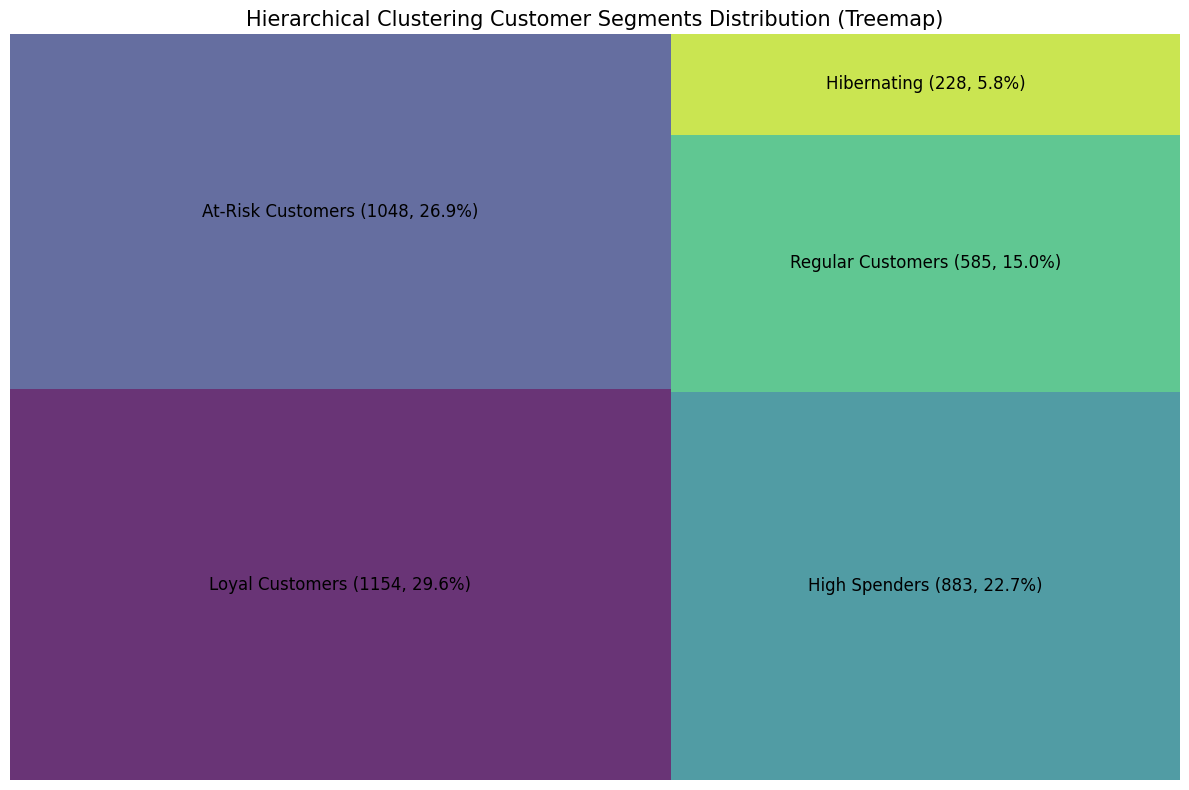

In [158]:
# visualization in tree map
# For Hierarchical segmentation
fig_hierarchical = plot_segment_treemap(
    rfm_df, 
    segment_column='Hierarchical_Segment',
    title='Hierarchical Clustering Customer Segments Distribution (Treemap)'
)
fig_hierarchical.show()



In [159]:
rfm_df

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Score,Customer_Segment_manual,Cluster,KMeans_Segment,Hierarchical_Cluster,Hierarchical_Segment
0,1000,35,5,53.80,4,3,2,9,Regular Customers,4,Loyal Customers,5,Loyal Customers
1,1001,242,5,100.00,2,3,3,8,Regular Customers,3,At-Risk Customers,5,Loyal Customers
2,1002,122,4,70.30,3,2,2,7,Regular Customers,4,Loyal Customers,5,Loyal Customers
3,1003,323,4,60.65,1,2,2,5,Inactive Customers,3,At-Risk Customers,3,At-Risk Customers
4,1004,28,8,204.96,4,4,4,12,VIP Customers,2,High Spenders,1,High Spenders
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,4996,36,3,28.50,4,2,1,7,Occasional Customers,0,Regular Customers,4,Regular Customers
3894,4997,3,2,93.00,4,2,3,9,Regular Customers,0,Regular Customers,5,Loyal Customers
3895,4998,77,1,33.00,3,1,1,5,Occasional Customers,0,Regular Customers,4,Regular Customers
3896,4999,4,6,164.86,4,4,4,12,VIP Customers,2,High Spenders,1,High Spenders


In [160]:
    # print(f"Cluster {i+1}: Recency={row['Recency']:.1f}, Frequency={row['Frequency']:.1f}, Monetary=${row['Monetary']:.2f}")
scaled_centers = rfm_df.groupby('Hierarchical_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

hierarchical_results = {
    'linkage_matrix': Z,
    'cluster_summary': h_cluster_summary,
    'scaler': hierachical_scaler,
    'centers_scaled': scaled_centers, # <-- Add the scaled centers here
    'mapping': h_cluster_mapping,
    'segmented_df': rfm_df[['Member_number', 'Recency', 'Frequency', 'Monetary', 'Hierarchical_Cluster', 'Hierarchical_Segment']] # Keep the segmented df if you want
}


In [161]:

# Save the updated dictionary
with open('data/hierarchical_segments.pkl', 'wb') as f:
    pickle.dump(hierarchical_results, f)

In [162]:
kmeans_results = {
    'model': kmeans,
    'cluster_centers': cluster_centers,
    'cluster_summary': cluster_summary,
    'scaler':scaler,
    'mapping':cluster_mapping,
    'segmented_df': rfm_df[['Member_number', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'KMeans_Segment']]
}

with open('data/kmeans_segments.pkl', 'wb') as f:
    pickle.dump(kmeans_results, f)

In [163]:
# Crosstab to compare Hierarchical clustering and Manual
comparison2_df = pd.crosstab(rfm_df['Customer_Segment_manual'], rfm_df['Hierarchical_Segment'])
print("Comparison between manual segmentation and Hierarchical_Segment clustering:")
comparison2_df

Comparison between manual segmentation and Hierarchical_Segment clustering:


Hierarchical_Segment,At-Risk Customers,Hibernating,High Spenders,Loyal Customers,Regular Customers
Customer_Segment_manual,,,,,
Big Spenders,9,0,204,66,0
Inactive Customers,683,228,63,1,0
Occasional Customers,194,0,1,54,457
Regular Customers,161,0,51,988,128
VIP Customers,1,0,564,45,0


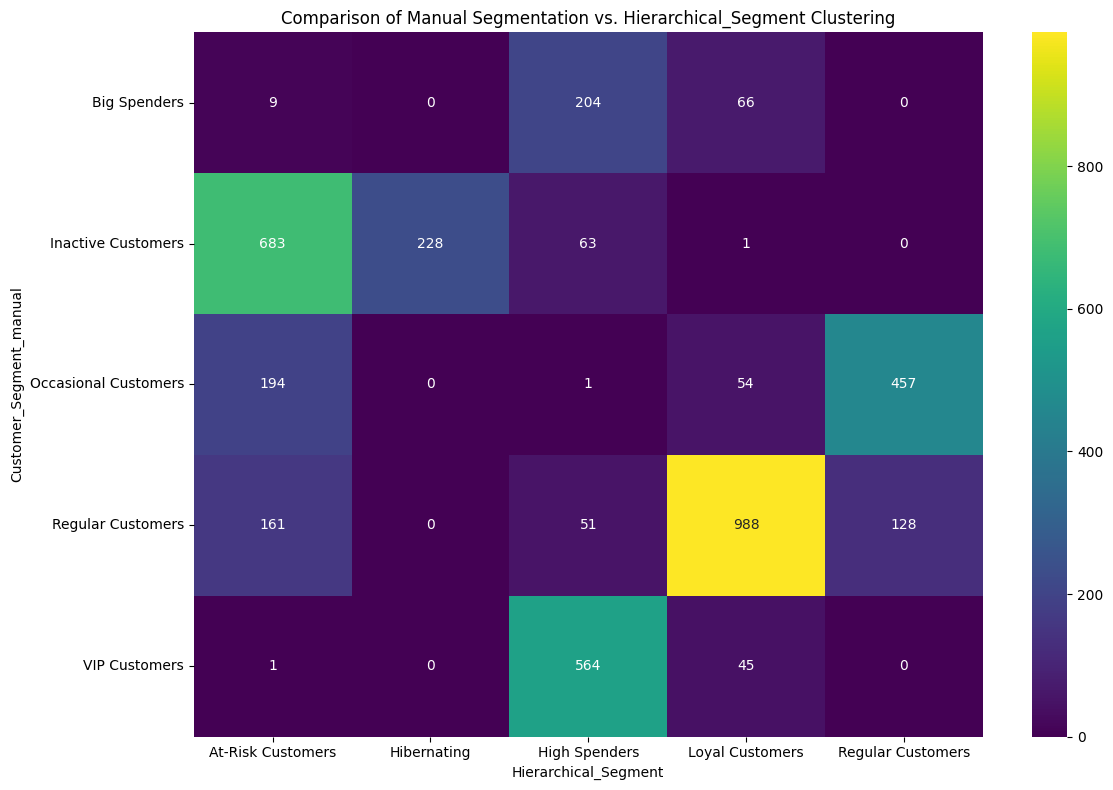

In [164]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(comparison2_df, annot=True, cmap='viridis', fmt='d')
plt.title('Comparison of Manual Segmentation vs. Hierarchical_Segment Clustering')
plt.tight_layout()
plt.show()

#### Comments: comparision between Manual and Hierarchical Clustering Comparison


## Key Observations

1. **Inactive Customers**: 
- Strong alignment - 228 manually labeled as "Inactive Customers" were classified as "Hibernating", bigger number classified as "At-Risk" by Hierarchical Clusterin.

2. **VIP Customers**: 
- 564 were classified as "High Spenders",45 as "Loyal Customers." This indicates hierarchical clustering is making finer distinctions within what the manual approach considers VIP customers.

3. **Big Spenders**: 
- Good alignment - 204 were classified as "High Spenders," 9 as "At-Risk Customers," and 66 as "Loyal Customers." This suggests hierarchical clustering considers additional factors beyond just spending amount.

4. **Regular Customers**:
- Primarily classified as "Loyal Customers" (998) with some as "Regular" (128), but also 161 were classified as At-Risk by Hierachical. 

5. **Occasional Customers**:
- Widely distributed across hierarchical segments
- Most alligned with Regular Customers classified by Hierarchical Clustering.


## Business Implications

1. The hierarchical clustering provides more granular segmentation than the manual approach, particularly for the broad "Occasional Customers" category.

2. The manual approach may be oversimplifying customer behavior, especially for customers who don't fall clearly into the high-value or inactive categories.



### Compare between KMeans and Hierachical

In [165]:
# let's have a comparision between K Means and Hierachial Clustering
comparison3_df = pd.crosstab(rfm_df['KMeans_Segment'], rfm_df['Hierarchical_Segment'])
print("Comparison between KMeans and Hierarchical_Segment clustering:")
comparison3_df

Comparison between KMeans and Hierarchical_Segment clustering:


Hierarchical_Segment,At-Risk Customers,Hibernating,High Spenders,Loyal Customers,Regular Customers
KMeans_Segment,,,,,
At-Risk Customers,430,0,75,117,0
Hibernating,388,228,0,0,0
High Spenders,0,0,531,3,0
Loyal Customers,0,0,277,781,8
Regular Customers,230,0,0,253,577


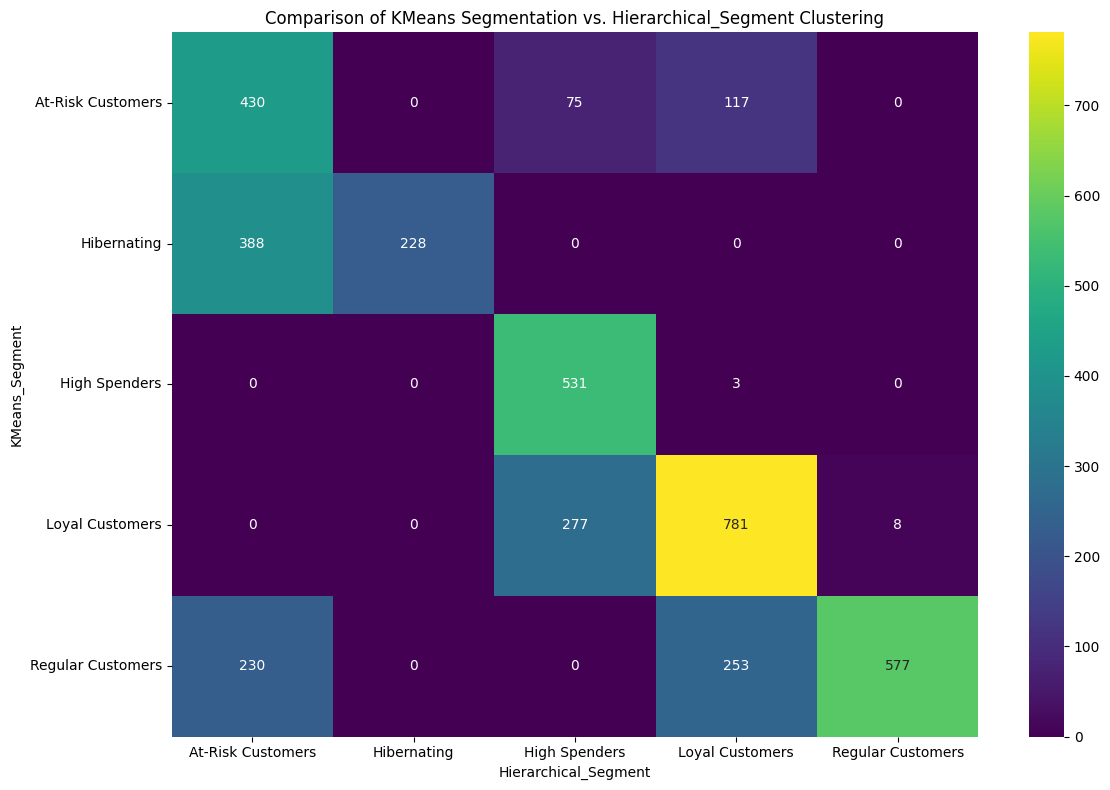

In [166]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(comparison3_df, annot=True, cmap='viridis', fmt='d')
plt.title('Comparison of KMeans Segmentation vs. Hierarchical_Segment Clustering')
plt.tight_layout()
plt.show()

### Comment: comparision between KMeans and Hierachical Clustering

# Alignment Analysis Between K-means and Hierarchical Clustering

Looking more carefully at the crosstab in comparison3_df, I can provide a more accurate analysis of the alignment between these two clustering methods:

## Key Observations

1. **Hibernating Customers**: 
- There's good alignment for this segment.

2. **High Spenders**:
- Very strong alignment with 305 customers classified as "High Spenders" by both methods.

3. **At-Risk Customers**: 
- Moderate alignment - 430 customers are classified as "At-Risk Customers" by both methods, but K-means also classifies 230 of hierarchical's "Regular Customers" as "At-Risk".

4. **Loyal Customers**:
- Strong alignment -  781 customers are classified as "Loyal Customers" by both methods. 277 Loyal Customers was classified as "High Spenders" by Hierachical.

5. **Regular Customers**:
-  Moderate alignment alignment - 577 customers are classified as "Regular Customers" by both methods, but hierarchical clustering also classifies 230 of K-means' "At-Risk Customers" as "Regular Customers".
